In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import procrustes
from scipy.linalg import pinv
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colormaps
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE


# read data from the Merritt Ruhlen database of phoneme data
# Download pnas.1424033112.sd01.txt from
#  https://www.pnas.org/doi/10.1073/pnas.1424033112#supplementary-materials

ruhlen = pd.read_csv(
    "pnas.1424033112.sd01.txt",
    sep="\t", quotechar='"', comment="#")

# Filter for living languages
ruhlen = ruhlen.loc[ruhlen["currPopulation"] > 0]

# filter for Niger-Congo languages
ruhlen = ruhlen.loc[ruhlen["topLevelClass"] == "Niger-Congo"]


In [2]:
# Process data in the Ruhlen database to deal with languages
#  that are recorded twice (each time with different phonemes)
ruhlen_clean = {}

columns = ruhlen.columns[1:]
for column in columns:
    ruhlen_clean[column] = []
    
# For each language, return that language's info if it is in the database once.
#  Otherwise, find the average presence/absence per feature per language.
for iso, count in zip(*np.unique(ruhlen["iso-6"], return_counts=True)):
    
    row = ruhlen["iso-6"].str.contains(iso)
    
    if count == 1:
        for column in columns:
            ruhlen_clean[column].append(ruhlen[row][column].values[0])
    
    else:
        average_vals = False
        for column in columns:
            if average_vals:
                ruhlen_clean[column].append(ruhlen[column][row].mean())
            else:
                ruhlen_clean[column].append(ruhlen.iloc[row.idxmax()][column])
            
            if column == "Latitude":
                average_vals = True
                
ruhlen_clean = pd.DataFrame(ruhlen_clean)


In [3]:
# set up the sci-kit learn model to run PCA
pca = PCA(n_components=2)
# extract phonemes, ignoring the metadata in the first 10 rows
phonemes_for_pca = ruhlen_clean.iloc[:, 10:].values
# center the data
phonemes_for_pca -= phonemes_for_pca.mean(axis=0)
# run the model on centered data
pca.fit(phonemes_for_pca.T)


PCA(n_components=2)

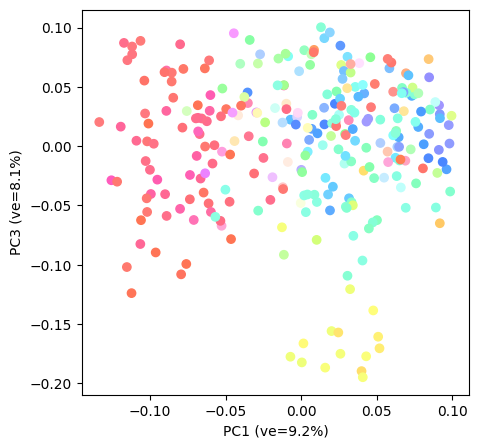

In [4]:
# color points based on geography
pcaColors = [i for i in zip(
    ruhlen_clean.Latitude.argsort().argsort() / len(ruhlen_clean),
    ruhlen_clean.Longitude.argsort().argsort() / len(ruhlen_clean))
]
yellowCyanRedBlue = [
    np.array(x)
    for x in [[1, 1, 0],
              [0, 1, 0.8],
              [1, 0, 0],
              [0, 0, 1]]]
pcaColors = [
    (lambda n: n / np.sum(n)) (np.array([
        np.exp(-(3 * (1 - x[0]) * (1 - x[1])) ** 2),
        np.exp(-(3 * x[0] * (1 - x[1])) ** 2),
        np.exp(-(3 * (1 - x[0]) * x[1]) ** 2),
        np.exp(-(3 * x[0] * x[1]) ** 2)
    ])) @ yellowCyanRedBlue
    for x in pcaColors
]
pcaColors = [
    (lambda n: 1 * n / np.max(n)) (x + (x - np.mean(x)) ** 2)
    for x in pcaColors
]

# plot the first two PCs with their associated variances explained
plt.figure(figsize=(5, 5))

plt.scatter(pca.components_[0, :], pca.components_[1, :],
            c=pcaColors)
plt.xlabel("PC1 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[1] * 100))
plt.show()



In [5]:
coords_geo = np.c_[ruhlen_clean.Latitude.values, ruhlen_clean.Longitude.values]

# run procrustes of coords vs linguistic PCA:
fit_pca, disparity = procrustes(
    coords_geo, pca.components_.T)[1:]

# get the scaling factor to rescale the fit coordinates
scaling_factor = np.sqrt(
    np.trace(np.dot((coords_geo - np.mean(coords_geo, axis=0)).T,
                    coords_geo - np.mean(coords_geo, axis=0))
            ))

# get the transformation that centered the coordinates
transformation_factor = np.mean(coords_geo, axis=0)

# calculate the geographic coordinates of the procrustes-rotated fit linguistic PCA
#  by scaling and transforming them
coords_from_fit_pca = fit_pca * scaling_factor + transformation_factor


In [6]:
# Project the first 2 PCs onto to map, after their procrustes rotation and transformation

# since:
#   ( rotation matrix ) dot ( original_pca ) = ( rotated_pca )
# to retrieve the rotation matrix we do:
#   (rotation matrix ) = inverse( original_pca ) dot (rotated_pca)
rotation = pinv(pca.components_).T @ fit_pca

# The transformed axis of PC1, the line connecting PC1=-0.15 to PC1=0.15 at PC2=0:
n1 = np.array([[-0.15, 0], [0.15, 0]]) @ rotation * scaling_factor + transformation_factor

# The transformed axis of PC2, the line connecting PC2=-0.15 to PC2=0.15 at PC1=0:
n2 = np.array([[0, -0.15], [0, 0.15]]) @ rotation * scaling_factor + transformation_factor


[[23.56552111 -9.22939533]
 [ 0.26186492 15.09682694]]
[[24.07680414 14.5855439 ]
 [-0.24941812 -8.71811229]]


/home/pichkary/.local/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


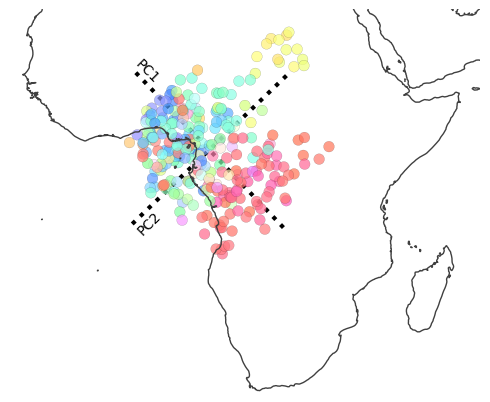

In [7]:
# set up the plotting
plt.figure(figsize=(5, 5))
# set up the map
ax = plt.axes(projection=ccrs.EckertIII(15))
ax.add_feature(COASTLINE.with_scale('50m'), color='#404040')
ax.set_extent([
    -20,  # Longitude/X-coords
    55,
    -35,  # Latitude/Y-coords
    25
], crs=ccrs.PlateCarree())

# scatter points
plt.scatter(
    coords_from_fit_pca[:, 0], coords_from_fit_pca[:, 1],
    c=pcaColors, marker='o', edgecolor='k', linewidth=0.1,
    s=60, alpha=0.7,
    transform=ccrs.PlateCarree())

# plot PC1 line and text
plt.plot(n1[:, 0], n1[:, 1], c='k', linewidth=3, linestyle=":",
         zorder=0, transform=ccrs.PlateCarree())
plt.text(n1[1, 0] - 0.5, n1[1, 1] - 1.5, "PC1", rotation=-45, transform=ccrs.PlateCarree())

# plot PC2 line and text
plt.plot(n2[:, 0], n2[:, 1], c='k', linewidth=3, linestyle=":",
         zorder=0, transform=ccrs.PlateCarree())
plt.text(n2[1, 0] + 0.5, n2[1, 1] - 1.5, "PC2", rotation=45, transform=ccrs.PlateCarree())

plt.tight_layout()
plt.box(False)
# plt.savefig("geographic_procrustes_fit_2PC.pdf", dpi=300)
plt.show()

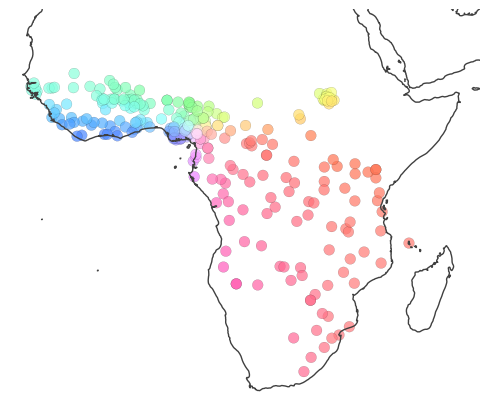

In [8]:
plt.figure(figsize=(5, 5))
ax = plt.axes(projection=ccrs.EckertIII(15))
# ax.add_feature(LAND, color='#C0C0C0')
ax.add_feature(COASTLINE.with_scale('50m'), color='#404040')
ax.set_extent([
    -20,  # Longitude is X-coords
    55,
    -35,  # Latitude is Y-coords
    25
], crs=ccrs.PlateCarree())

plt.scatter(
#     coords_from_fit_pca[:, 0], coords_from_fit_pca[:, 1],
    coords_geo[:, 0], coords_geo[:, 1],
    c=pcaColors, marker='o', edgecolor='k', linewidth=0.1,
    s=60, alpha=0.7,
    transform=ccrs.PlateCarree())

plt.tight_layout()
plt.box(False)
# plt.savefig("geographic_coloring.pdf", dpi=300)
plt.show()

### Doing a similar Procrustes analysis in three dimensions:

In [9]:
# set up the sci-kit learn model to run PCA
pca = PCA(n_components=3)

# run the model on centered data
pca.fit(phonemes_for_pca.T)


PCA(n_components=3)

In [11]:
def geo_to_xyz(mtrx):
    # converts a longitude-latitude matrix (each row is a pair of coordinates)
    #  to cartesian XYZ space
    
    latitude = mtrx[:, 1] * np.pi / 180
    longitude = mtrx[:, 0] * np.pi / 180

    X = np.cos(latitude) * np.cos(longitude)
    Y = np.cos(latitude) * np.sin(longitude)
    Z = np.sin(latitude)

    return np.c_[X, Y, Z]


def xyz_to_geo(mtrx):
    # converts a matrix representing points in cartesian XYZ space
    #  (each row is a set of coordinates) to longitude-latitude values
    
    mtrxSum = np.sqrt(np.sum(mtrx ** 2, axis=1))
        
    lati = np.arcsin(mtrx[:, 2] / mtrxSum)
    lati *= 180 / np.pi

    longi = np.arctan2(mtrx[:, 1], mtrx[:, 0])
    longi *= 180 / np.pi

    return np.c_[longi, lati]


coords_geo = np.c_[ruhlen_clean.Latitude.values, ruhlen_clean.Longitude.values]

# 3D procrustes

# convert latitude/longitude into 3d cartesian space
coords_3d = geo_to_xyz(coords_geo)
# center and scale the data
transformation_factor = coords_3d.mean(axis=0)
scaling_factor = np.sqrt(
    np.trace(np.dot((coords_3d - transformation_factor).T,
                    (coords_3d - transformation_factor)))
)

coords_3d = (coords_3d - transformation_factor) / scaling_factor

# run procrustes
fit_coords, fit_pca, disparity = procrustes(coords_3d, pca.components_.T)

# reverse the centering to be able to plot the points as latitude/longitude
coords_from_fit_pca = xyz_to_geo(fit_pca * scaling_factor + transformation_factor)

# for plotting
coords_from_fit_pca[:, 0] = coords_from_fit_pca[:, 0] + (coords_from_fit_pca[:, 0] < 0) * 360
coords_geo[:, 0] = coords_geo[:, 0] + (coords_geo[:, 0] < 0) * 360


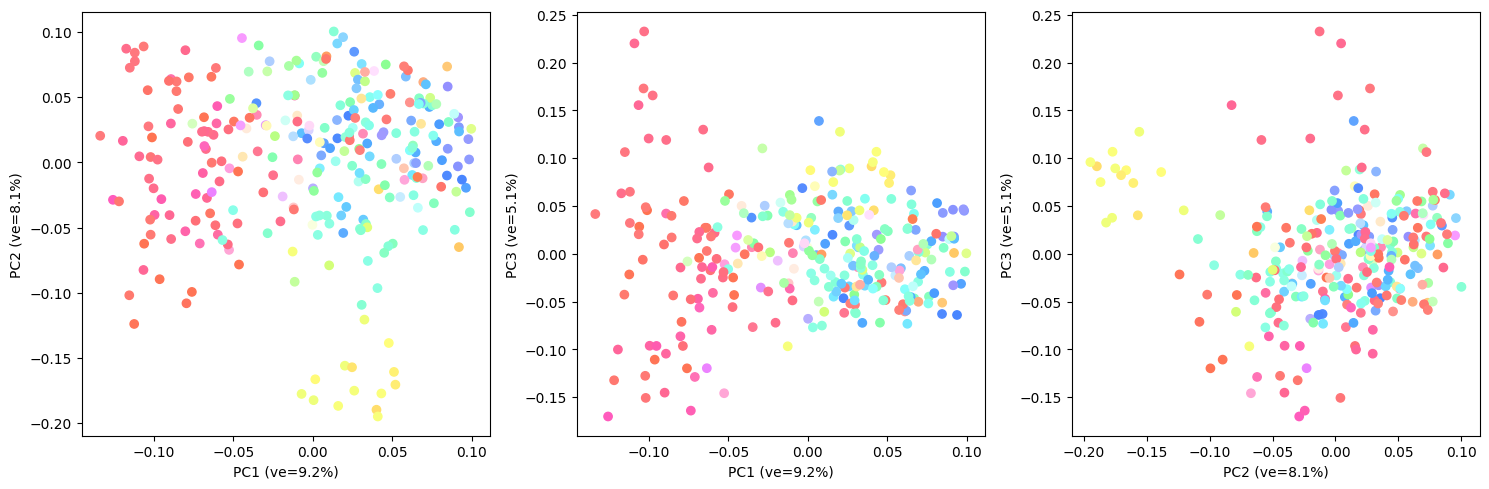

In [15]:
# plot the first three PCs with their associated variances explained
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.scatter(pca.components_[0, :], pca.components_[1, :],
            c=pcaColors)
plt.xlabel("PC1 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[1] * 100))

plt.subplot(132)
plt.scatter(pca.components_[0, :], pca.components_[2, :],
            c=pcaColors)
plt.xlabel("PC1 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC3 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[2] * 100))

plt.subplot(133)
plt.scatter(pca.components_[1, :], pca.components_[2, :],
            c=pcaColors)
plt.xlabel("PC2 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[1] * 100))
plt.ylabel("PC3 (ve={:3.1f}%)".format(pca.explained_variance_ratio_[2] * 100))

plt.tight_layout()
plt.show()

In [27]:
# Project the first 3 PCs onto to map, after their procrustes rotation and transformation

# since:
#   ( rotation matrix ) dot ( original_pca ) = ( rotated_pca )
# to retrieve the rotation matrix we do:
#   (rotation matrix ) = inverse( original_pca ) dot (rotated_pca)
rotation = pinv(pca.components_).T @ fit_pca

# The transformed axis of PC1, the line connecting PC1=-0.2 to PC1=0.2 at PC2=0 and PC3=0:
n1 = np.array([[-0.2, 0, 0], [0.2, 0, 0]]) @ rotation * scaling_factor + transformation_factor
n1 = xyz_to_geo(n1)

# The transformed axis of PC2, the line connecting PC2=-0.2 to PC2=0.2 at PC1=0 and PC3=0:
n2 = np.array([[0, -0.2, 0], [0, 0.2, 0]]) @ rotation * scaling_factor + transformation_factor
n2 = xyz_to_geo(n2)

# The transformed axis of PC3, the line connecting PC3=-0.2 to PC3=0.2 at PC1=0 and PC2=0:
n3 = np.array([[0, 0, -0.2], [0, 0, 0.2]]) @ rotation * scaling_factor + transformation_factor
n3 = xyz_to_geo(n3)

print(n1, n2, n3)

[[22.23915532 -8.12145901]
 [ 0.86224971 14.55713087]] [[23.20102675 13.32733416]
 [ 0.22022657 -7.67214866]] [[10.6405034   2.97948598]
 [13.94239845  3.30826414]]


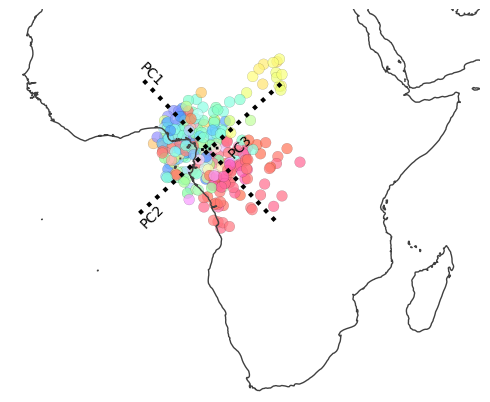

In [28]:
# set up the plotting
plt.figure(figsize=(5, 5))
# set up the map
ax = plt.axes(projection=ccrs.EckertIII(15))
ax.add_feature(COASTLINE.with_scale('50m'), color='#404040')
ax.set_extent([
    -20,  # Longitude/X-coords
    55,
    -35,  # Latitude/Y-coords
    25
], crs=ccrs.PlateCarree())

# scatter points
plt.scatter(
    coords_from_fit_pca[:, 0], coords_from_fit_pca[:, 1],
    c=pcaColors, marker='o', edgecolor='k', linewidth=0.1,
    s=60, alpha=0.7,
    transform=ccrs.PlateCarree())

# plot PC1 line and text
plt.plot(n1[:, 0], n1[:, 1], c='k', linewidth=3, linestyle=":",
         transform=ccrs.PlateCarree())
plt.text(n1[1, 0] - 0.5, n1[1, 1] - 1.5, "PC1", rotation=-45, transform=ccrs.PlateCarree())

# plot PC2 line and text
plt.plot(n2[:, 0], n2[:, 1], c='k', linewidth=3, linestyle=":",
         transform=ccrs.PlateCarree())
plt.text(n2[1, 0] + 0.5, n2[1, 1] - 1.5, "PC2", rotation=45, transform=ccrs.PlateCarree())

# plot PC3 line and text
plt.plot(n3[:, 0], n3[:, 1], c='k', linewidth=2, linestyle=":",
         transform=ccrs.PlateCarree())
plt.text(n3[1, 0] + 0.5, n3[1, 1] - 1.5, "PC3", rotation=45, transform=ccrs.PlateCarree())


plt.tight_layout()
plt.box(False)
# plt.savefig("geographic_procrustes_fit_3PC.pdf", dpi=300)
plt.show()